In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, chi2
import ipywidgets as widgets
from IPython.display import display

# Parameters
alpha = 0.05  # 95% CL
mu_true_max = 20
n_max = 40
mu_vals = np.linspace(0, mu_true_max, 200)
n_vals = np.arange(0, n_max+1)

# ----------------------------
# Feldman-Cousins Neyman belt
# ----------------------------
def feldman_cousins_belt(mu_vals, n_vals, alpha=0.05):
    belt = dict()
    for mu in mu_vals:
        p_n = poisson.pmf(n_vals, mu)
        mu_best = n_vals
        p_n_best = poisson.pmf(n_vals, mu_best)
        R = p_n / p_n_best
        sort_idx = np.argsort(-R)
        cum_prob = 0
        selected_n = []
        for idx in sort_idx:
            n = n_vals[idx]
            selected_n.append(n)
            cum_prob += p_n[idx]
            if cum_prob >= 1-alpha:
                break
        belt[mu] = np.sort(selected_n)
    return belt

belt = feldman_cousins_belt(mu_vals, n_vals, alpha)

# ----------------------------
# FC interval for observed n
# ----------------------------
def feldman_cousins_interval(n_obs, mu_vals, belt):
    included_mu = [mu for mu in mu_vals if n_obs in belt[mu]]
    if len(included_mu) == 0:
        return None, None
    return min(included_mu), max(included_mu)

# ----------------------------
# Interactive plotting function
# ----------------------------
def plot_dashboard(n_obs):
    # ----------------------------
    # Frequentist CI
    ci_lower = 0.5 * chi2.ppf(alpha/2, 2*n_obs)
    ci_upper = 0.5 * chi2.ppf(1-alpha/2, 2*(n_obs+1))

    # Bayesian CI
    posterior = gamma(a=n_obs+1, scale=1.0)
    bayes_lower = posterior.ppf(alpha/2)
    bayes_upper = posterior.ppf(1-alpha/2)

    # Feldman-Cousins interval
    fc_low, fc_high = feldman_cousins_interval(n_obs, mu_vals, belt)

    # ----------------------------
    # Figure with 2 subplots
    fig, ax = plt.subplots(1,2, figsize=(14,6))

    # --- Left: Posterior + intervals ---
    lambda_vals = np.linspace(0, max(ci_upper, bayes_upper, fc_high if fc_high else 0)+5, 500)
    ax[0].plot(lambda_vals, posterior.pdf(lambda_vals), label='Posterior (Bayesian)', color='purple')
    ax[0].axvline(bayes_lower, color='purple', linestyle='--', label='Bayesian 95% CI')
    ax[0].axvline(bayes_upper, color='purple', linestyle='--')
    ax[0].axvline(ci_lower, color='green', linestyle=':', label='Frequentist 95% CI')
    ax[0].axvline(ci_upper, color='green', linestyle=':')
    if fc_low is not None:
        ax[0].axvspan(fc_low, fc_high, color='orange', alpha=0.3, label='Feldman-Cousins 95% CI')
    ax[0].set_title(f'Intervals for Observed n = {n_obs}')
    ax[0].set_xlabel(r'True $\mu$')
    ax[0].set_ylabel('Probability density / Interval')
    ax[0].legend()
    ax[0].grid(True)

    # --- Right: Neyman belt ---
    for mu in mu_vals[::5]:
        ax[1].plot([mu]*len(belt[mu]), belt[mu], 'b.', markersize=2)

    if fc_low is not None:
        ax[1].axvspan(fc_low, fc_high, color='orange', alpha=0.3, label='FC 95% CI')
    ax[1].axhline(n_obs, color='red', linestyle='--', label=f'Observed n={n_obs}')

    ax[1].set_xlabel(r'True $\mu$')
    ax[1].set_ylabel('Observed n')
    ax[1].set_title('Feldman-Cousins Neyman Belt')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    # ----------------------------
    # Print numerical intervals
    print(f"Observed n = {n_obs}")
    print(f"Frequentist 95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"Bayesian 95% Credible Interval: [{bayes_lower:.2f}, {bayes_upper:.2f}]")
    if fc_low is not None:
        print(f"Feldman-Cousins 95% CL interval: [{fc_low:.2f}, {fc_high:.2f}]")
    else:
        print(f"Feldman-Cousins interval not found for n = {n_obs}")

# ----------------------------
# Interactive slider
n_slider = widgets.IntSlider(value=3, min=0, max=n_max, step=1, description='Observed n:')
widgets.interact(plot_dashboard, n_obs=n_slider)


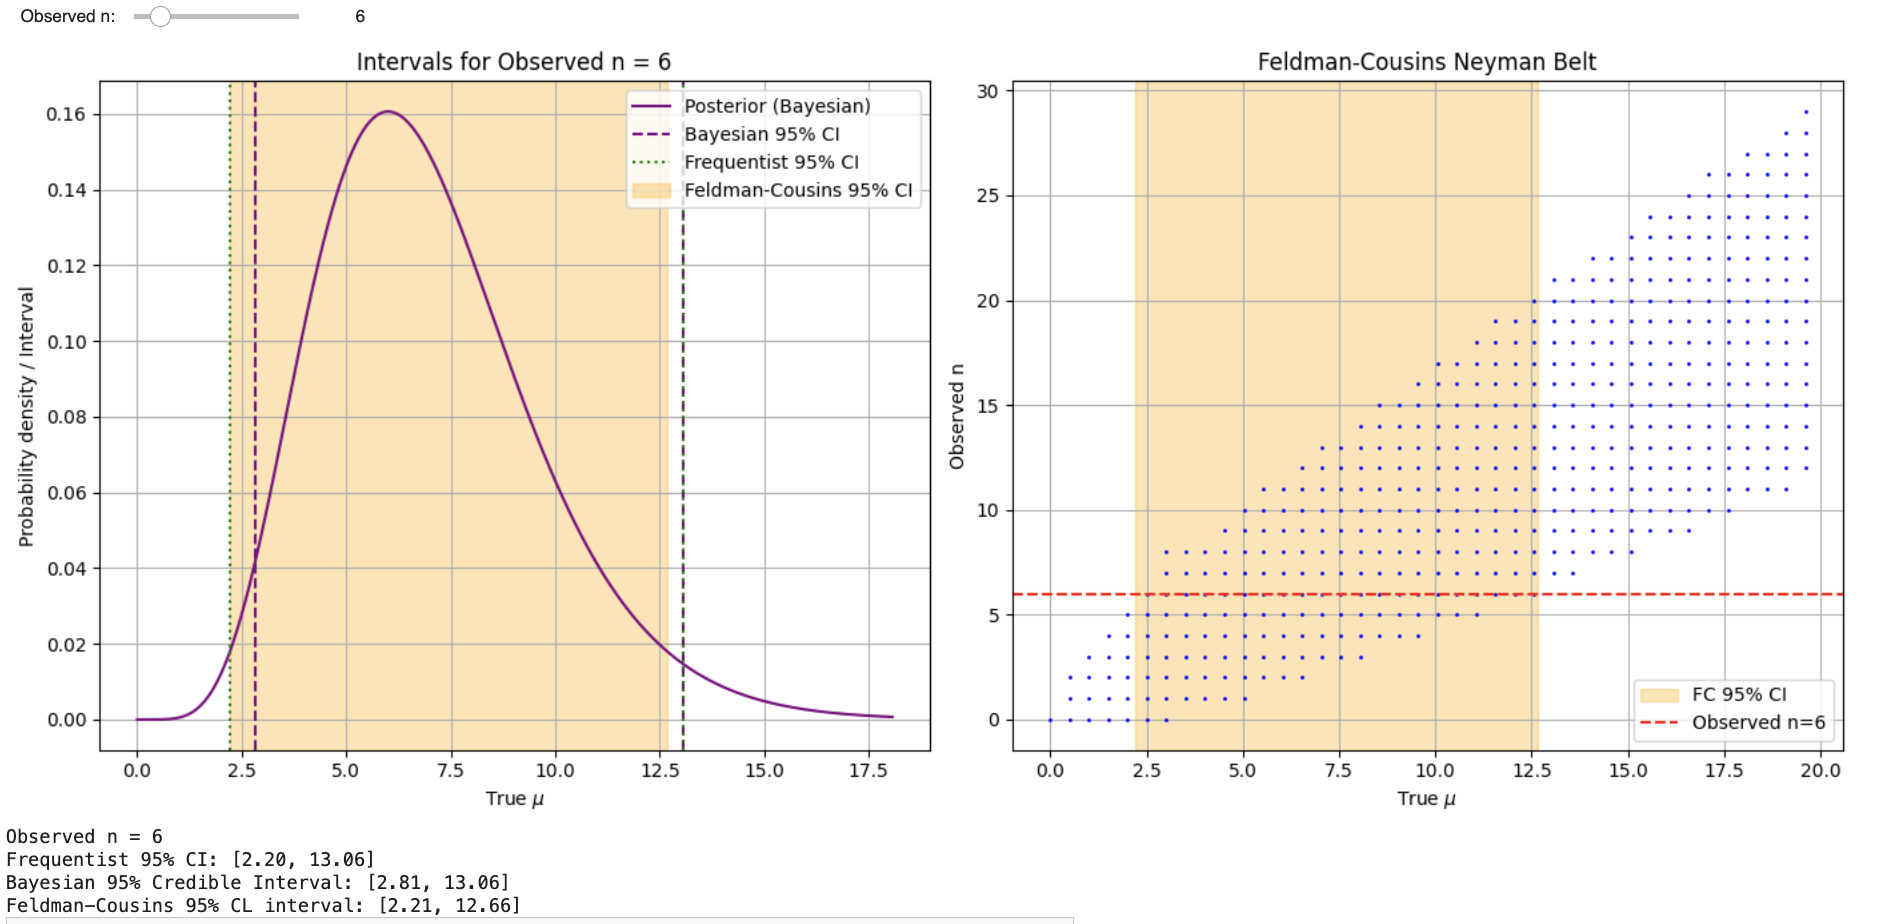
